In [2]:
import numpy as np
import math
# Module to display T/F matrix
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# Module for Unit testing
import pytest
# Module for convolutionnal decoder
import sk_dsp_comm.fec_conv as fec


In [3]:
my_data = np.genfromtxt('./tfMatrix.csv', delimiter=';')
mat_complex = my_data[:,0::2] +1j*my_data[:,1::2]
print(len(mat_complex))

14


#1

 la taille de la matrice est 14 car FFT a comme taille  1024 et 14 symbole par frame. 

  On doit récupérer juste la partie qui nous concerne à savoir les 624. les 312 premieres et la 2ème partie sera les 312 autres. le reste sera généralement du bruit ou idéalement des 0 dans notre cas. Il faut aussi sougliner qu'à la fréquence 0, on pas de signal 


In [30]:
 #-- Getting allocated subcarriers
tfMatrix_short = np.zeros((14, 624),dtype=np.complex128)
for i in range(0,13): 
    tfMatrix_short[i] = np.append(mat_complex[i][1:313], mat_complex[i][712:1024])
# print(tfMatrix_short)

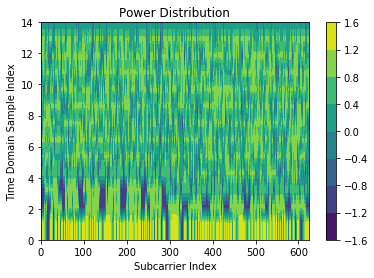

In [31]:
def powerDistributionGraph(Z):
    # Draw the power distribution graph
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0, len(Z), len(Z)), Z)
    cbar = fig.colorbar(cs)
    ax.set_title('Power Distribution')
    ax.set_xlabel('Subcarrier Index')
    ax.set_ylabel('Time Domain Sample Index')

powerDistributionGraph(tfMatrix_short)


In [39]:
# --- Removing PSCH and SSCH channels
qamMatrix = tfMatrix_short[2:, :]

# print(qamMatrix)

In [51]:
#2.2.1
pbch_symbols = qamMatrix[0,0:24]  #pour pbch on a 48 bit dans la OFFDM 3 (voir la figure dans le sujet) mais apres FEC il reste que 24 

# print(pbch_symbols) c'est bien du 2-QAM car le resultat est que des 1 et des -1.

In [66]:
def bpsk_demod(qamSeq):
    bitSeq = []
    for qam in qamSeq:
        if qam.real > 0:
            bitSeq.append(1)
        else:
            bitSeq.append(0)
    return bitSeq

In [67]:
from tests_modulation import test_bpsk
test_bpsk()


NameError: name 'bpsk_demod' is not defined